# Statistical process of experimental measurments

In our lab some measurements of local velocity were made with a CTA probe (see for example the [Wikipedia page for hot-wire anemometry](https://en.wikipedia.org/wiki/Anemometer#Hot-wire_anemometers), or the [Dantec information](https://www.dantecdynamics.com/solutions-applications/solutions/fluid-mechanics/constant-temperature-anemometry-cta/measurement-principles-of-cta/))

The measurements were performed in the wake behind a NACA profile with 5 degrees incidence angle

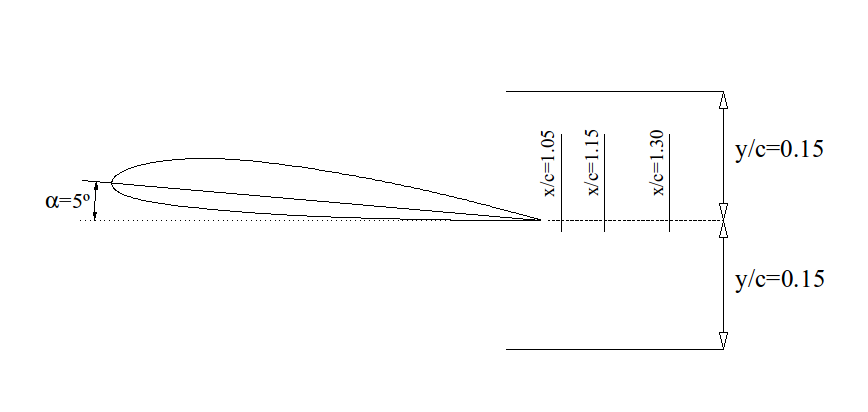

The data provided have been acquired at a distance of, approximately, $\frac{x}{c} \approx 1.1$, where $c = 265 \,\text{mm}$ is the profile's chord. and there are 17 $y$ positions, 
from $y=-4 \,\text{cm}$ to $y=+4 \,\text{cm}$, in intervals of 5 mm. In each point the velocity has been acquired for a second with a frequency of 1 kHz (that is, 1000 velocities in each point). It has been measured only the $x$ component (main flow direction).

Most of the topics covered in this notebook have been consulted in the [CFD-online Wiki page "Introduction to turbulence"](https://www.cfd-online.com/Wiki/Introduction_to_turbulence)

In [ ]:
import pandas as pd
import numpy as np

We define the names for the columns, according with the definition

In [ ]:
columns = []
for i in range(17):
    y = (i-8)*5
    columns.append("y = "+np.str(y)+"mm")

In [ ]:
turbulenceData = pd.read_csv('TurbVel.csv',delimiter=',', index_col=0,names=columns)

In [ ]:
turbulenceData.index.name="Time"

In [ ]:
turbulenceData.head()

If we want to save this data in another file, keeping the information for index, columns, etc... instead of csv, we can use a more powerful format, as HDF. This is a Hierarchical Data Format, widely used to store big amounts of data in a organized way. More information, in the [HDF group web page](https://www.hdfgroup.org/solutions/hdf5) or in [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_Data_Format).

In [ ]:
turbulenceData.to_hdf("TurbVel.hdf","w")

We can then get again the data with the format provided

In [ ]:
newTurbulenceData = pd.read_hdf("TurbVel.hdf")

In [ ]:
newTurbulenceData

In [ ]:
del(newTurbulenceData)

We can easily plot velocity time series in any point

In [ ]:
turbulenceData["y = 0mm"].plot(ylabel="u")

And also we can get the main features

In [ ]:
statData = turbulenceData.describe()
statData

In [ ]:
statData.loc["mean"].plot(title="Mean velocities")

## Computation of turbulence intensities

Remember the definition of turbulence intensity: 

$$ I = \frac{\sqrt{\overline{u'^2}}}{\bar{u}} $$

where the numerator is, precisely, the `std` index of our statistical data.

In [ ]:
turbIntensity = statData.loc["std"]/statData.loc["mean"]

In [ ]:
turbIntensity.plot(title="Turbulence Intensity")

## Computation of fluctuations

By definition, in each point the fluctuation of velocity is 

$$ u' = u  - \overline{u} $$

In [ ]:
turbVelFluct = turbulenceData-statData.loc["mean"]

In [ ]:
turbVelFluct.plot(subplots=True,layout=(4,5),figsize=(20,20),color="b",sharey=True);

## Computation of turbulence kinetic energy

The turbulent kinetic energy (TKE), $k$ is computed as

$$ k = \frac{1}{2}\overline{\boldsymbol{u'}\cdot\boldsymbol{u'}} = \frac{1}{2} \overline{u'_i u'_i}$$

and we should need also $v'$ and $w'$. We are then only computing the contribution of $u'$ to TKE. Note that although main flow is in the $x$ direction and components of velocities $u$ and $v$ can be neglected, it is not possible for fluctuating velocities $v'$ and $w'$. They can be as important as $u'$. We can make the assumption that turbulence, at small scales, is isotropic and, hence $\overline{u'}^2 \approx \overline{v'}^2 \approx \overline{w'}^2 $ and

$$ k \approx \frac{3}{2}\overline{u'}^2 $$

In [ ]:
TKE = 1.5*statData.loc["std"]**2

In [ ]:
TKE.plot()

## Some time scales

For the moment, we focus on $y = 0 \,\text{mm}$ time series. The TKE in this point is

In [ ]:
k = TKE.loc["y = 0mm"]
k

The turbulence Reynolds number, locally defined in this point, is calculated with a length scale, which can be estimated, for now, as the larger eddy in the flow, of the order of the profile's chord. 

$$ \text{Re}_t = \frac{\sqrt{k}c}{\nu} $$

We need also the viscosity of air.

In [ ]:
nu = 1.5e-5 # m^2/s
c = 0.265 # m
Re_t = np.sqrt(k)*c/nu
print('Re_t = {:.5g}'.format(Re_t))

The [Kolmogorov time scale](https://en.wikipedia.org/wiki/Kolmogorov_microscales) can be estimated as

$$ \tau_k = \sqrt{\frac{\nu}{\varepsilon}} $$

where $\varepsilon$ is the energy dissipation rate, that can be estimated as 

$$ \varepsilon = \frac{k^{\frac{3}{2}}}{c} $$ 

(it is considered that energy is injected at larger scales)

In [ ]:
epsilon = k**1.5/c
epsilon # m^2/s^3

And the Kolmogorov time scale is, approximately,

In [ ]:
tau_k = np.sqrt(nu/epsilon)
tau_k

that is of the order of our time resolution.

An integral time scale is defined with the autocorrelation of time signal. 

$$ R(\tau) = \overline{u'(t)u'(t+\tau)} $$

Computing autocorrelation is very time consuming, but pandas has a [plotting method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html) that performs this computation much faster. The problem is that the output is directly a plot, and it is tricky to get the autocorrelation values from it.

In [ ]:
uPrime = turbVelFluct["y = 0mm"].values
pd.plotting.autocorrelation_plot(uPrime);

In [ ]:
autocorr = pd.plotting.autocorrelation_plot(uPrime).get_lines()[5].get_xydata()

We change the "lag" $x$ numbers with time lag, form the Data Frame

In [ ]:
autocorr[:,0]=turbVelFluct.index.values

And also zoom for a narrower $x$ span. Note that the pandas function gives the normalized correlation $\rho(\tau)=\frac{R(\tau)}{R(0)} $.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(autocorr[:,0],autocorr[:,1],'o-')
ax = plt.gca()
ax.set_xlim(0,0.2)
ax.set_ylabel(r"$R(\tau)$")
ax.set_xlabel(r"\tau")
ax.set_title("Autocorrelation for y = 0 mm");

The integral time scale is defined as the integral of autocorrelation function

In [ ]:
from scipy import integrate

In [ ]:
T = integrate.trapezoid(autocorr[:,1],autocorr[:,0])

In [ ]:
T

It gives a very small (negative) value because the number of samples (1000) is still very low to get a good autocorrelation for large lag. It is assumed that after the second or third root, the autocorrelation is zero. So, we change the limits of integration:

In [ ]:
T = integrate.trapezoid(autocorr[0:50,1],autocorr[0:50,0])

In [ ]:
T

This method has the inconvenient that there is not the lag 0. It should be included in the very first point.

Alternatively, the statistic models package provides a better way to estimate autocorrelation, even with the option of choosing the number of lags for the computation.

In [ ]:
import statsmodels.api as sm

In [ ]:
rho = sm.tsa.acf(uPrime,nlags=50,fft=False)
rho

In [ ]:
import statsmodels.graphics.api as smg

In [ ]:
smg.tsa.plot_acf(autocorr[:,1],lags=200,fft=False)

The computation of the integral time is more accurate because of the 0-lag point.

In [ ]:
T = integrate.trapezoid(rho[0:50],autocorr[0:50,0])
T

## Histogram and PDF

PDF is the Probability Density Function. It defines the probability of an event between to values. For example, if the pdf of our velocity fluctuation is  $f(x)$, then the probability that a value of the fluctuation lies between $u'_1$ and $u'_2$ is 

$$ P\left(u'_1 < u' < u'_2\right) = \int_{u'_1}^{u'_2} f(x) dx $$ 

In [ ]:
import scipy.stats as stats

In [ ]:
X = stats.norm(0,1)

In [ ]:
X_samples= X.rvs(100)

In [ ]:
F, bins, patches = plt.hist(uPrime,bins=100,density=True) # Integral = 1

Since we have included the option `density=True`, the integral (moment of order 0) of this PDF is 1.

$$ M_0 = \int_{-\infty}^{+\infty} f(u') du' = 1 $$

In [ ]:
deltaUPrime = np.diff(bins) 

In [ ]:
M0 = np.sum(F*deltaUPrime)
M0

The moment of order 1 is the average of the samples, that should be 0

$$ M_1 = \overline{u'} = \int_{-\infty}^{+\infty} u' f(u') du' = 0 $$

In [ ]:
UPrimePDF = bins[:-1] + deltaUPrime/2

In [ ]:
M1 = np.sum(UPrimePDF*F*deltaUPrime)
M1

The moment of order 2 is the variance of the samples, that should be the square of the standard deviation given by pandas before...

$$ M_2 = \overline{u'^2} = \int_{-\infty}^{+\infty} u'^2 f(u') du' $$

In [ ]:
M2 = np.sum(UPrimePDF**2*F*deltaUPrime)
M2

In [ ]:
statData["y = 0mm"].loc["std"]**2

The moment of order 3 is 

$$ M_3 = \overline{u'^3} = \int_{-\infty}^{+\infty} u'^3 f(u') du' $$

The _skewness_ of the $u'$ distribution is defined as 

$$ S = \frac{M_3}{M_2^\frac{3}{2}} $$

In [ ]:
M3 = np.sum(UPrimePDF**3*F*deltaUPrime)
M3

In [ ]:
S = M3/M2**1.5
S

The moment of order 4 is 

$$ M_4= \overline{u'^4} = \int_{-\infty}^{+\infty} u'^4 f(u') du' $$

The _kurtosis_ of the $u'$ distribution is defined as 

$$ K = \frac{M_4}{M_2^2} $$

For a normal distribution, it should be 3 (check it)

In [ ]:
M4 = np.sum(UPrimePDF**4*F*deltaUPrime)
M4

In [ ]:
K = M4/M2**2
K

## Power spectrum

Finally, from the time series signal, we can get the spectrum in frequency by performing a Fast Fourier Transform 

In [ ]:
E = np.abs(np.fft.fft(uPrime))

plt.plot(E)

In [ ]:
freq = np.fft.fftfreq(uPrime.size,0.001)
plt.plot(freq,E)

In [ ]:
E = E[:int(len(E)/2)]
freq = freq[:int(len(freq)/2)]
plt.plot(freq,E)

In [ ]:
P = E**2
plt.plot(freq,E)

In [ ]:
fig, ax = plt.subplots(1)
ax.set_ylim(1,1e5)
ax.loglog(freq,P)
f_plot = np.logspace(1,2.7,100)
f_ref = 10
P_ref = 1e5
P_plot = P_ref/f_ref**(-5/3)*f_plot**(-5/3)
ax.loglog(f_plot,P_plot,'--')
ax.text(30,20000,'-5/3')

In [ ]:
rho = sm.tsa.acf(uPrime,nlags=999,fft=False)
smg.tsa.plot_acf(uPrime,lags=999,fft=False)

In [ ]:
Pr = np.abs(np.fft.fft(rho))
plt.plot(Pr)

In [ ]:
freq = np.fft.fftfreq(rho.size,0.001)
Pr = E[:int(len(Pr)/2)]
freq = freq[:int(len(freq)/2)]

In [ ]:
fig, ax = plt.subplots(1)
ax.set_ylim(1,1000)
ax.loglog(freq,Pr)
f_plot = np.logspace(1,2.7,100)
f_ref = 30
P_ref = 500
P_plot = P_ref/f_ref**(-5/3)*f_plot**(-5/3)
ax.loglog(f_plot,P_plot,'--')
ax.text(100,100,'-5/3')

***
## **Assignment** : Computation of length scales and $k$ spectrum

We have fluctuations of velocity in time, but not in space. In order to get fluctuations of velocity in space (for a given time $t_0$) we should have an array of anemometers very close to each other (microns, probably), which is quite difficult (it is much more easier for CFD results). 

Fortunately, there is the [Taylor hypothesis] (https://www-sciencedirect-com.recursos.biblioteca.upc.edu/science/article/pii/B9780080443508500014#p15)( see also [Pope\[2000\]](https://discovery.upc.edu/iii/encore/record/C__Rb1253705?lang=cat) p. 223), which says that if turbulence can be considered (average) steady and fluctuations are much smaller than average velocity, time can be replaced by $x/\overline{u}$.

The assignment is to make all this analysis and find, in space:

- Kolmogorov's scale
- Taylor's scale
- Autocorrelation function
- Integral scale
- Power spectrum (in $k$) and check the Kolmogorov's power law.

***
